In [149]:
data_path = "../data/dataset_nov_21.sqlite3"
image_path = "../public/images"

In [11]:
import os
import numpy as np
import matplotlib
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt

import sqlite3
from sqlite3 import Error

In [201]:
# Plot params.

plt.rc('font', family='Lato', weight='bold')
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

sns.set_context('notebook', font_scale=1)

In [68]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

In [191]:
conn = create_connection(data_path)

with conn:
    cur = conn.cursor()
    cur.execute("SELECT * FROM experimentalCatchments")
    rows = cur.fetchall()
    df= pd.DataFrame(rows,columns=[i[0] for i in cur.description])
    df=df.loc[:,[cur.description[i][0] for i in [10,13,16,19,20,22,0,1]]]
    df["sign_change_annual_streamflow"]=np.sign(df.change_annual_streamflow_mm)
    df["sign_change_low_flow"]=np.sign(df.change_low_flow)
    df["sign_change_peak_flow"]=np.sign(df.change_peak_flow)
    df["sign_change_groundwater_recharge"]=df.change_groundwater_recharge

df = df.rename(columns={'change_annual_streamflow_mm': 'change_annual_streamflow'})

# Change +1 and -1 into + and –
for sig_col in [col for col in df.columns if col.startswith('sign_')]:
    df[sig_col] = df[sig_col].apply(lambda val: '+' if val == 1.0 else '–')

df.head(4)

,change_annual_streamflow,change_low_flow,change_peak_flow,change_groundwater_recharge,treatment_class,fraction_treated,catchment_name,site_name,sign_change_annual_streamflow,sign_change_low_flow,sign_change_peak_flow,sign_change_groundwater_recharge
0,-14.0,-3.4,0.4,None,Deforestation,0.25,FC-1,"Fox Creek, Oregon, USA",–,–,+,–
1,-6.0,-1.2,0.7,None,Deforestation,0.25,FC-3,"Fox Creek, Oregon, USA",–,–,+,–
2,102.0,NaN,NaN,None,Deforestation,0.52,XF1,"Upper Bear Creek, Alabama, USA",+,–,–,–
3,297.0,NaN,NaN,None,Deforestation,0.82,XF2,"Upper Bear Creek, Alabama, USA",+,–,–,–


In [235]:
effects = [
    'change_annual_streamflow',
    'change_low_flow',
    'change_peak_flow',
#     'change_groundwater_recharge'
]

effect_labels = [
    'Annual flow change',
    'Low flow change',
    'Peak flow change',
#     'Groundwater recharge'
]

treatments = [
    'Deforestation',
    'Afforestation'
]

## For each effect, plot all treatments

In [193]:
def plot_single_effect_all_treatments(effect, effect_label,
                                      query=None, palette=None,
                                      hue='site_name'):
    if query:
        data = df.query(query)
    else:
        data = df
        
    fig, ax = plt.subplots()
    
    hues = sorted(data[hue].unique())
    if len(hues) == 2:
        palette = [
            (0.5098039215686274, 0.7764705882352941, 0.8862745098039215), # blue
            (0.8392156862745098, 0.37254901960784315, 0.37254901960784315)  # red
        ]
    
    sns.despine(ax=ax)
    g = sns.swarmplot(
        data=data,
        y=effect,
        x='treatment_class',
        hue=hue,
        size=14,
        palette=palette,
        hue_order=hues,
        ax=ax,
    )
    plt.hlines(0, -1, len(df['treatment_class'].unique()))
    ax.set_xlabel('')
    ax.set_ylabel(effect_label)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    handles, legend_labels = ax.get_legend_handles_labels()
    legend = ax.get_legend()
    legend.remove()
    
    legend_fig, legend_ax = plt.subplots()
    legend_fig.legend(handles, legend_labels, loc='center', frameon=False)
    legend_ax.set_axis_off()
    
    fig.set_figwidth(6)    
    return fig, legend_fig

# plot_single_effect_all_treatments(effect, effect_label, hue='sign_change_peak_flow')

This will plot both the plots and separately their legends

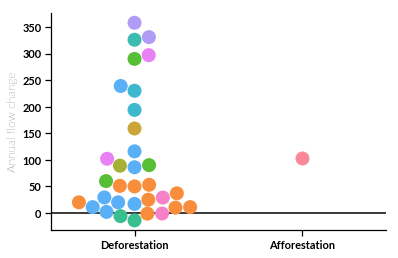

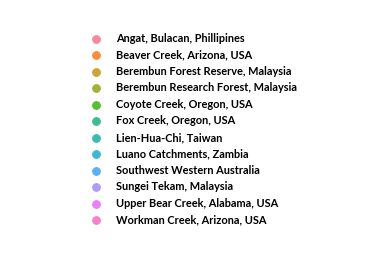

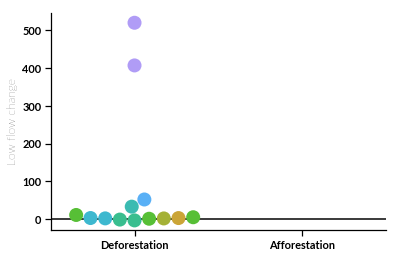

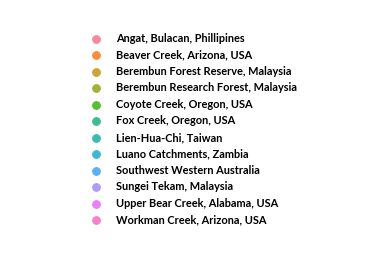

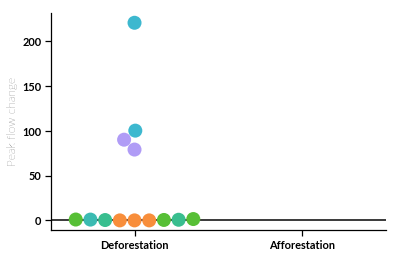

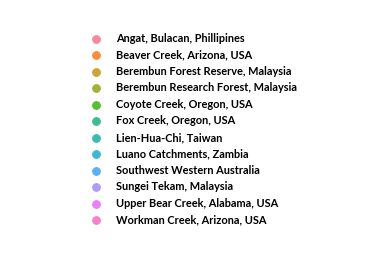

In [202]:
for effect, effect_label in zip(effects, effect_labels):
    fig, legend = plot_single_effect_all_treatments(effect, effect_label)
    fig.savefig('%s/%s_sites.svg' % (image_path, effect))

legend.savefig('%s/sites_legend.svg' % image_path)

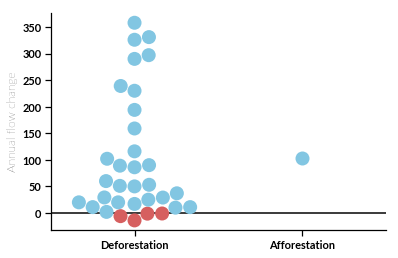

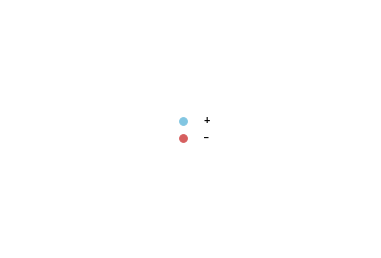

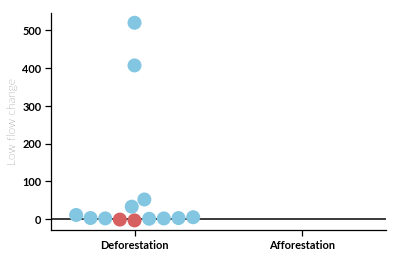

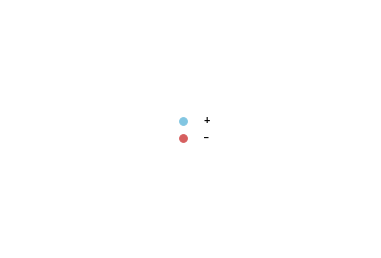

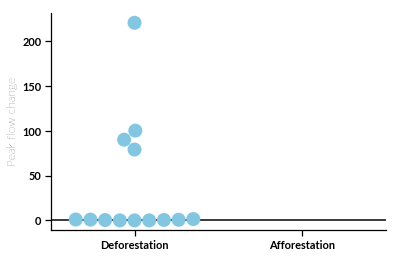

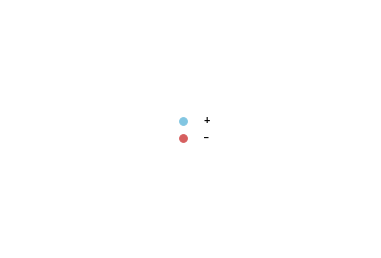

In [196]:
for effect, effect_label in zip(effects, effect_labels):
    fig, legend = plot_single_effect_all_treatments(effect, effect_label, hue='sign_' + effect)
    fig.savefig('%s/%s_signs.svg' % (image_path, effect))

legend.savefig('%s/signs_legend.svg' % image_path)

## For each treatment, plot all effects

In [228]:
melt_df = df.melt(id_vars='treatment_class', value_vars=effects)
melt_df.head()

,treatment_class,variable,value
0,Deforestation,change_annual_streamflow,-14.0
1,Deforestation,change_annual_streamflow,-6.0
2,Deforestation,change_annual_streamflow,102.0
3,Deforestation,change_annual_streamflow,297.0
4,Deforestation,change_annual_streamflow,-1.3


In [286]:
def plot_all_effects_single_treatment(treatment,
                                      query=None, palette=None,
                                      hue='site_name'):
    if query:
        data = df.query(query)
    else:
        data = df
    
    grid = sns.FacetGrid(melt_df, col='variable')

    for (effect, effect_label, ax) in zip(effects, effect_labels, grid.axes[0]):
        data_treatment = df.query('treatment_class=="%s"' % treatment)
        if hue == 'sign_':
            hue = 'sign_' + effect
            
        hues = sorted(data_treatment[hue].unique())
        if len(hues) == 2:
            palette = [
                (0.5098039215686274, 0.7764705882352941, 0.8862745098039215), # blue
                (0.8392156862745098, 0.37254901960784315, 0.37254901960784315)  # red
            ]
        
        sns.swarmplot(data=data_treatment,
                      x='treatment_class', y=effect,
                      hue=hue,
                      ax=ax)
        ax.set_xlabel('')
        ax.set_xticklabels([''])
        ax.set_ylabel(effect_label, fontdict={'weight': 'regular'})
        ax.get_legend().remove()

    grid.fig.set_figwidth(8)

    return grid

# plot_all_effects_single_treatment('Deforestation', hue='sign_')

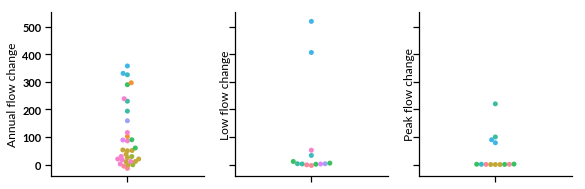

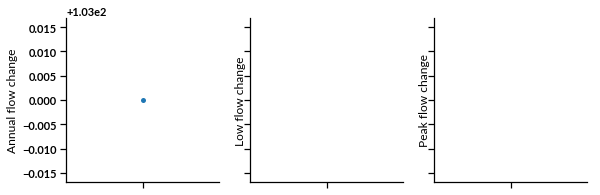

In [287]:
for treatment in treatments:
    grid = plot_all_effects_single_treatment(treatment, hue='site_name')
    grid.fig.savefig('%s/%s_sites.svg' % (image_path, treatment))

## Full grid (treatments x effects)

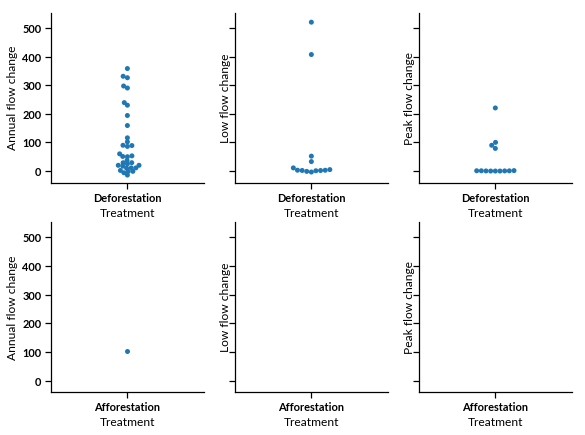

In [285]:
grid = sns.FacetGrid(melt_df, col='variable', row='treatment_class',
                     sharex=False)

for i, treatment in enumerate(treatments):
    for (effect, effect_label, ax) in zip(effects, effect_labels, grid.axes[i]):
        sns.swarmplot(data=df.query('treatment_class=="%s"' % treatment),
                      x='treatment_class', y=effect, ax=ax)
        
        ax.set_xlabel('Treatment', fontdict={'weight': 'regular'})
        ax.set_ylabel(effect_label, fontdict={'weight': 'regular'})

grid.fig.set_figwidth(8)